In [58]:
'''
#Gigacow-tools# - preprocessing
This scripts used for single cow data collection work.
Data Tables: gigacow_filter.csv, lactation_filter.csv, traffic_raw_filter.csv
'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#access data from local directory
dataDir = "E:/Data/processed/"
gigacow_cols = ['AnimalNumber', 'FarmName_Pseudo', 'BreedName', 'Age']
lactation_cols = ['AnimalNumber', 'FarmName_Pseudo', 'LactationInfoDate', 'LactationNumber', 'DaysInMilk']
gigacow = pd.read_csv(dataDir + 'gigacow_filter.csv', encoding='utf-8', usecols=gigacow_cols)
lactation = pd.read_csv(dataDir + 'lactation_filter.csv', encoding='utf-8', usecols=lactation_cols)
traffic = pd.read_csv(dataDir + 'traffic_raw_filter.csv', encoding='utf-8', index_col=False)
#check out cows with most milking events
print(traffic.Gigacow_Cow_Id.value_counts().nlargest(10))

3147    2242
6000    2231
4478    2172
6197    2170
3757    2119
6405    2118
560     2029
1181    2028
90      2027
3535    1984
Name: Gigacow_Cow_Id, dtype: int64


In [9]:
#select single cow from the traffic table
traffic_single_cow = traffic.loc[traffic['Gigacow_Cow_Id'] == 2528]
traffic_single_cow.sort_values(by='TrafficEventDateTime', inplace=True)
traffic_single_cow.index = range(len(traffic_single_cow))

'''
    Extract Milking Event and its most recent traffic event to calculate T2-T1
    T1: Entry time into the Mjolkfalla
    T2: Entry time into the milking robot
    T2-T1: calculate time difference between T2&T1 (i.e., Time spend in Mjolkfalla/holding area)
'''
# locate mikling event by searching 'kg' keyword in traffic result
# the most recent traffic event to milking event should be pre_milking event
# need to filter out records with gate failure
track_milking = traffic_single_cow.TrafficResult.str.contains('kg', regex=False)
milking_index_list = track_milking.index[track_milking.values == True].tolist()
pre_milking_index_list = [x-1 for x in milking_index_list]
milking_traffic = traffic_single_cow[traffic_single_cow.index.isin(milking_index_list)]
pre_milking_traffic = traffic_single_cow[traffic_single_cow.index.isin(pre_milking_index_list)]

# drop rows that the gate failed to detect cows but have milking result
# previous area in milking_traffic table should only be Mjolkfalla
# previous area in pre_milking_traffic table should not be Mjolkfalla
failed_list_1_milk = milking_traffic.index[milking_traffic['PreviousArea'] == 'Koridor till Sorteringsgrind 2'].tolist()
failed_list_1_pre = [x-1 for x in failed_list_1_milk]
failed_list_2_pre = pre_milking_traffic.index[pre_milking_traffic['PreviousArea'] == 'Mjolkfalla'].tolist()
failed_list_2_milk = [x+1 for x in failed_list_2_pre]
# traffic result in pre_milking_traffic table should contain Mjolkfalla
track_pre_milking = pre_milking_traffic.TrafficResult.str.contains('Mjolkfalla', regex=False)
failed_list_3_pre = track_pre_milking.index[track_pre_milking.values == False].tolist()
failed_list_3_milk = [x+1 for x in failed_list_3_pre]

# remove failed records based on index list
milking_traffic_failed = failed_list_1_milk + failed_list_2_milk + failed_list_3_milk
pre_milking_traffic_failed = failed_list_1_pre + failed_list_2_pre + failed_list_3_pre
milking_traffic.drop(axis=0, index=milking_traffic_failed, inplace=True)
pre_milking_traffic.drop(axis=0, index=pre_milking_traffic_failed, inplace=True)
# concatenate two tables to track the traffic directly
all_milking_traffic = pd.concat([milking_traffic, pre_milking_traffic])
all_milking_traffic.sort_values(by=['TrafficEventDateTime'], inplace=True)
#rename table columns for merging
milking_traffic.rename(columns={"TrafficEventDateTime": "MilkingEventDateTime", "TrafficResult": "MilkProduction", "TimeInArea_totalSeconds": "RoundedSecondsTimeInArea"}, inplace=True)
pre_milking_traffic.rename(columns={"TrafficEventDateTime": "Pre_MilkingEventDateTime", "TimeInArea_totalSeconds": "RoundedSecondsTimeInArea"}, inplace=True)
# unify the index of two tables
milking_traffic.index = range(len(milking_traffic))
pre_milking_traffic.index = range(len(pre_milking_traffic))
# inert "pre_traffic_milking" to milking traffic table
milking_traffic.insert(5, 'Pre_MilkingEventDateTime', pre_milking_traffic['Pre_MilkingEventDateTime'])
# calculate T2-T1
milking_traffic.MilkingEventDateTime = pd.to_datetime(milking_traffic.MilkingEventDateTime)
milking_traffic.Pre_MilkingEventDateTime = pd.to_datetime(milking_traffic.Pre_MilkingEventDateTime)
milking_traffic['timeDelta_Seconds'] = (milking_traffic['MilkingEventDateTime'] - milking_traffic['Pre_MilkingEventDateTime']).dt.total_seconds()

#extract traffic result(milk production)
milking_traffic['MilkProduction'].replace(r"[^0-9.,]+"," ", inplace=True, regex=True)
milking_traffic['MilkProduction'].replace(r"\s*","", inplace=True, regex=True)
milking_traffic['MilkProduction'].replace(r"[,]+",".", inplace=True, regex=True)
milking_traffic['MilkProduction'] = milking_traffic['MilkProduction'].astype('float64')

# merge all the other features into milking_traffic table
milking_traffic['MilkingDate'] = milking_traffic.MilkingEventDateTime.dt.date
milking_traffic.MilkingDate = pd.to_datetime(milking_traffic.MilkingDate)
lactation.LactationInfoDate = pd.to_datetime(lactation.LactationInfoDate)
single_cow_merge = milking_traffic.merge(lactation, how='left', left_on=['FarmName_Pseudo', 'AnimalNumber', 'MilkingDate'], right_on=['FarmName_Pseudo', 'AnimalNumber', 'LactationInfoDate'])
single_cow_merge = single_cow_merge.merge(gigacow, how='left', left_on=['FarmName_Pseudo', 'AnimalNumber'], right_on=['FarmName_Pseudo', 'AnimalNumber'])

# drop failed data points based on RoundedSecondsTimeInArea & timeDelta_Seconds
single_cow_merge.drop(single_cow_merge.loc[abs(single_cow_merge.timeDelta_Seconds - single_cow_merge.RoundedSecondsTimeInArea) > 300].index, inplace=True)

# write the collection result to local directory
single_cow_collection = single_cow_merge[['Gigacow_Cow_Id', 'BreedName', 'Age', 'FarmName_Pseudo', 'GroupName', 'TrafficDeviceName', 'MilkProduction', 'timeDelta_Seconds', 'LactationNumber', 'DaysInMilk']]
single_cow_collection.to_csv(dataDir + 'single_cow_collection.csv')

C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_16368\2098027613.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traffic_single_cow.sort_values(by='TrafficEventDateTime', inplace=True)
C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_16368\2098027613.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  milking_traffic.drop(axis=0, index=milking_traffic_failed, inplace=True)
C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_16368\2098027613.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

<Figure size 432x288 with 0 Axes>

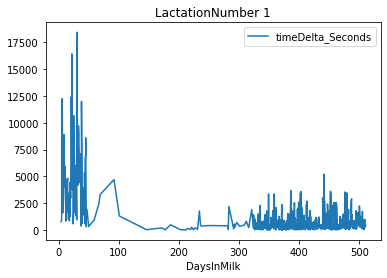

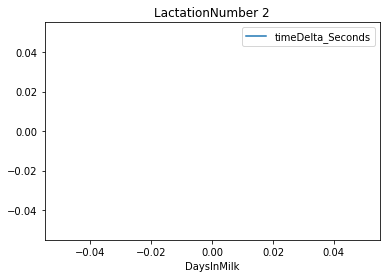

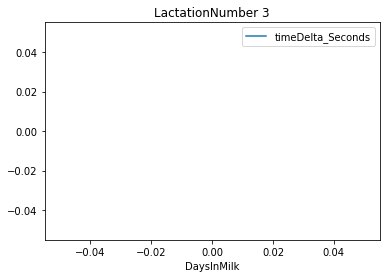

In [10]:
# plot the relations between timeDielta and Lactation/DIM(DaysInMilk)
plt.figure()
single_cow_collection.loc[single_cow_collection.LactationNumber == 1].plot(x="DaysInMilk", y="timeDelta_Seconds", kind='line', title='LactationNumber 1')
single_cow_collection.loc[single_cow_collection.LactationNumber == 2].plot(x="DaysInMilk", y="timeDelta_Seconds", kind='line', title='LactationNumber 2')
single_cow_collection.loc[single_cow_collection.LactationNumber == 3].plot(x="DaysInMilk", y="timeDelta_Seconds", kind='line', title='LactationNumber 3')
plt.show()


In [12]:
#all_milking_traffic.to_csv(dataDir+'all_milking_traffic.csv')
all_milking_traffic
#pre_milking_traffic.to_csv(dataDir+'pre_milking_traffic.csv')
pre_milking_traffic
#milking_traffic.to_csv(dataDir+'milking_traffic.csv')
milking_traffic
#single_cow_merge.to_csv(dataDir + 'single_cow_merge.csv')
single_cow_merge

,Traffic_Id,FarmName_Pseudo,AnimalNumber,Gigacow_Cow_Id,GroupName,Pre_MilkingEventDateTime,MilkingEventDateTime,PreviousArea,RoundedSecondsTimeInArea,TrafficDeviceName,MilkProduction,MilkingInterval_totalSeconds,timeDelta_Seconds,MilkingDate,LactationInfoDate,LactationNumber,DaysInMilk,BreedName,Age
0,1684951,f454e660,563,2528,Vms kor (144 platser),2020-12-19 13:44:33,2020-12-19 13:57:29,Mjolkfalla,720.0,vms 2,5.85,NaN,776.0,2020-12-19,2020-12-19,1,4.0,2,3.83
1,388551,f454e660,563,2528,Vms kor (144 platser),2020-12-20 16:11:10,2020-12-20 16:26:54,Mjolkfalla,900.0,vms 2,8.39,30060.0,944.0,2020-12-20,2020-12-20,1,5.0,2,3.83
2,5437562,f454e660,563,2528,Vms kor (144 platser),2020-12-21 13:03:39,2020-12-21 16:27:57,Mjolkfalla,12240.0,vms 2,15.04,56280.0,12258.0,2020-12-21,2020-12-21,1,6.0,2,3.83
3,5515663,f454e660,563,2528,Vms kor (144 platser),2020-12-22 01:33:00,2020-12-22 02:02:55,Mjolkfalla,1740.0,vms 2,8.79,33960.0,1795.0,2020-12-22,2020-12-22,1,7.0,2,3.83
4,2177060,f454e660,563,2528,Vms kor (144 platser),2020-12-22 09:42:28,2020-12-22 10:20:00,Mjolkfalla,2220.0,vms 2,8.42,29400.0,2252.0,2020-12-22,2020-12-22,1,7.0,2,3.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647,3796539,f454e660,563,2528,Vms kor (144 platser),2022-05-08 09:32:35,2022-05-08 09:47:36,Mjolkfalla,900.0,Vms 1,10.60,31920.0,901.0,2022-05-08,2022-05-08,1,509.0,2,3.83
648,1335564,f454e660,563,2528,Vms kor (144 platser),2022-05-08 20:16:42,2022-05-08 20:21:08,Mjolkfalla,240.0,Vms 1,12.39,37380.0,266.0,2022-05-08,2022-05-08,1,509.0,2,3.83
649,2500870,f454e660,563,2528,Vms kor (144 platser),2022-05-09 08:06:46,2022-05-09 08:11:31,Mjolkfalla,240.0,vms 2,10.20,42180.0,285.0,2022-05-09,2022-05-09,1,510.0,2,3.83
650,4724322,f454e660,563,2528,Vms kor (144 platser),2022-05-09 13:01:21,2022-05-09 13:09:47,Mjolkfalla,480.0,Vms 1,4.59,11820.0,506.0,2022-05-09,2022-05-09,1,510.0,2,3.83


In [53]:
# Select cows with sufficient data points on consecutive lactation periods
# Try to collect cow's data that contain milking events between lactation periods 1~2
lactation_cols = ['AnimalNumber', 'Gigacow_Cow_Id', 'FarmName_Pseudo', 'LactationInfoDate', 'LactationNumber', 'DaysInMilk']
lactation = pd.read_csv(dataDir + 'lactation_filter.csv', encoding='utf-8', usecols=lactation_cols)
# select records that contains lactation period 1
lactation_select1 = lactation.loc[lactation['LactationNumber'] == 1]
selected1 = lactation_select1.Gigacow_Cow_Id.value_counts(ascending=True)
selected1 = selected1.loc[(selected1.values > 280) & (selected1.values < 370)]
list1 = selected1.index.tolist()
# select records that contains lactation period 2
lactation_select2 = lactation.loc[lactation['LactationNumber'] == 2]
selected2 = lactation_select2.Gigacow_Cow_Id.value_counts(ascending=True)
selected2 = selected2.loc[(selected2.values > 280) & (selected2.values < 370)]
list2 = selected2.index.tolist()
cow_list = list(set(list1) & set(list2))

In [57]:
cow_list

[636,
 129,
 2569,
 1555,
 2195,
 919,
 920,
 5147,
 1181,
 560,
 562,
 1846,
 697,
 6485,
 4825,
 5470,
 478,
 5477,
 6380,
 2423,
 4220]

In [44]:
print(selected1.count())
selected1

51


2237    301
849     303
1796    306
2702    306
2039    311
943     313
5613    314
2278    320
4537    322
1555    322
769     323
5160    323
985     323
5092    325
1846    326
3707    326
4220    326
129     327
4825    328
5046    329
6380    330
2946    330
5147    331
4899    331
636     331
560     332
6086    337
1181    337
874     337
920     338
919     339
5470    341
2079    342
2569    342
1905    342
3531    344
2374    345
6428    345
3447    345
1587    346
6485    346
4704    348
478     350
4709    351
1738    352
1985    355
74      357
574     358
1393    359
5235    359
2423    359
Name: Gigacow_Cow_Id, dtype: int64

In [46]:
print(selected2.count())
selected2

40


3127    302
3641    303
1032    309
3113    311
926     316
478     320
6363    323
6352    325
3971    326
1846    328
560     330
2195    331
2354    332
5470    333
636     334
5147    334
4379    335
920     336
3121    336
5183    337
562     339
2423    340
802     341
4261    342
6027    342
4220    342
2712    345
5477    347
5343    349
1287    349
919     350
3844    350
2001    351
4825    352
182     355
5633    355
129     356
1582    358
1555    358
1583    359
Name: Gigacow_Cow_Id, dtype: int64

In [19]:
lactation_select

,FarmName_Pseudo,AnimalNumber,Gigacow_Cow_Id,LactationInfoDate,LactationNumber,DaysInMilk
0,a624fb9a,1394,5160,2021-09-08,1,67.0
1,f454e660,622,4311,2022-04-11,1,118.0
4,a624fb9a,1368,3207,2021-09-26,1,254.0
7,a624fb9a,1394,5160,2021-11-29,1,149.0
12,f454e660,483,3641,2021-02-26,1,259.0
...,...,...,...,...,...,...
192792,f454e660,489,4906,2021-09-16,1,368.0
192795,a624fb9a,1383,5465,2021-08-01,1,64.0
192796,a624fb9a,1426,4195,2022-04-20,1,47.0
192799,a624fb9a,1297,560,2020-12-27,1,352.0
